# Cart-Pole: Double Deep Q-Network (DDQN)

DDQN (modified version of DQN). The change is made in the Q-value calculator.

## Setup

In [31]:
import gym # Version 0.17.1
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [32]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [33]:
print("Using cuda:", torch.cuda.is_available())

Using cuda: True


## Deep Q-Network

In [34]:
class DQN(nn.Module):
    def __init__(self, num_state_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features=num_state_features, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)            

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Prioritized Exeprience Replay

### Experience Class

In [35]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
) 

In [36]:
Data = namedtuple(
    'Data', 
    ('priority', 'probability', 'weight', 'index')
)

In [37]:
e = Experience(2,3,1,4)
d = Data(1,2,3,4)
e, d

(Experience(state=2, action=3, next_state=1, reward=4),
 Data(priority=1, probability=2, weight=3, index=4))

### Replay Memory

In [38]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Strategies and Agents

### Training Agent

In [39]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [40]:
class TrainingAgent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(self.device) # exploit
    
    def get_exploration_rate(self):
        return strategy.get_exploration_rate(self.current_step)

### Testing Agent

In [41]:
class TestingAgent():
    """
    Uses the policy network to take the best action in the environment given the state.
    """
    def __init__(self, device):
        self.device = device
    
    def select_action(self, state, policy_net):
        with torch.no_grad(): # Turn off gradient tracking since we don't need to compute the gradient here
            return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(self.device)

## Environment Manager

In [42]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.done = False
        self.current_state = None
    
    def reset(self):
        self.current_state = self.env.reset()
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space.n
        
    def take_action(self, action):        
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def get_state(self):
         if self.done:
            return torch.zeros_like(torch.tensor(self.current_state), device=self.device).float()
         else:
            return torch.tensor(self.current_state, device=self.device).float()
        
    def num_state_features(self):
        return self.env.observation_space.shape[0]

### State Examples

In [43]:
# Create the environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)

In [44]:
# Starting state (random but close to upright)
em.reset()
em.get_state()

tensor([ 0.0115, -0.0207,  0.0428,  0.0360], device='cuda:0')

In [45]:
# State after taking 5 random actions
em.reset()
for i in range(5):
    em.take_action(torch.tensor([random.randint(0,1)]))
em.get_state()

tensor([-0.0664, -0.6148,  0.0123,  0.8261], device='cuda:0')

In [46]:
# Ending state (zero vector)
em.reset()
em.done = True
em.get_state()

tensor([0., 0., 0., 0.], device='cuda:0')

## Q-Value Calculator

In [47]:
# This class contains two static methods which mean we can call the methods without creating an instance of the class.
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        # Get the Q-value of a given state-action pair
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, policy_net, next_states):
        # Set the best Q-value of a final next-state to zero 
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        # Compute the best Q-value among all actions for a given next-state using the target net, but actions from the policy net
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        best_actions_from_policy_net = F.one_hot(policy_net(non_final_states).argmax(1), num_classes=2).bool()
        # Set the values of non-final states to the Q-values of the target net when taking the best action from the policy net
        values[non_final_state_locations] = target_net(non_final_states)[best_actions_from_policy_net].detach()
        return values

## Utility Functions

### Plotting

In [48]:
def get_moving_average(values, period=100):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

<Figure size 432x288 with 0 Axes>

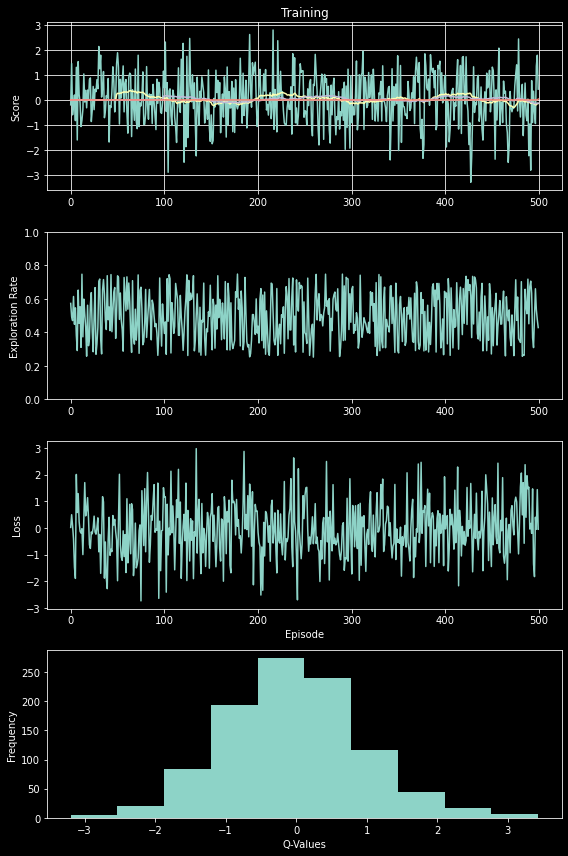

In [49]:
def plot(scores, exploration_rates, losses, qvalues):
    plt.clf();
    fig, axs = plt.subplots(4, 1, figsize=(8,12));
    
    axs[0].set_title("Training");
    axs[0].set_ylabel("Score");
    axs[0].plot(scores);
    axs[0].plot(get_moving_average(scores, period=50));
    axs[0].plot(get_moving_average(scores, period=100));
    axs[0].plot(get_moving_average(scores, period=500));
    axs[0].grid()
    
    axs[1].set_ylabel("Exploration Rate");
    axs[1].set_ylim([0, 1]);
    axs[1].plot(exploration_rates);
    
    axs[2].set_ylabel("Loss");
    axs[2].set_xlabel("Episode");
    axs[2].plot(losses);
    
    axs[3].set_ylabel("Frequency");
    axs[3].set_xlabel("Q-Values");
    axs[3].hist(qvalues[-1000:]);
    
    plt.tight_layout();
    
    plt.pause(0.001);
    if is_ipython: display.clear_output(wait=True);

scores = np.random.randn(500)
exploration_rates = np.random.random(500)/2 + 0.25
losses = np.random.randn(500)
qvalues = np.random.randn(10000)

plot(scores, exploration_rates, losses, qvalues);

### Tensor Processing

In [50]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches, and then turn them into PyTorch tensors
    batch = Experience(*zip(*experiences))
    t1, t2, t3, t4 = torch.stack(batch.state), torch.cat(batch.action), torch.cat(batch.reward), torch.stack(batch.next_state)
    return (t1,t2,t3,t4)

In [51]:
e1, e2, e3 = Experience(1,1,1,1), Experience(2,2,2,2), Experience(3,3,3,3)
experiences = [e1, e2, e3] # Batch of experiences
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [52]:
batch = Experience(*zip(*experiences))
batch # Experience of batches

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Main Program

### Hyperparameters

In [53]:
batch_size = 256
gamma = 0.999 # Discount rate in bellman equation
eps_start, eps_end, eps_decay = 0.1, 0.01, 0.0001 # Parameters for epsilon greedy strategy (try changing this)
target_update = 10 # Rate at which we update the target net
memory_size = 100000 # Size of replay memory
lr = 0.001 # Learning rate for the optimizer

### Initialization

In [54]:
# Create the classes defined above
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = TrainingAgent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.num_state_features()).to(device) # Create policy net
target_net = DQN(em.num_state_features()).to(device) # Create target net
target_net.load_state_dict(policy_net.state_dict()) # Copy policy net params to target net
target_net.eval() # Tell PyTorch to only use target net for evaluation purposes (do not train)
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) # Create an optimizer for gradient descent

### Training

Episode Number: 195
Average Score (100 episodes): 187.88


<Figure size 432x288 with 0 Axes>

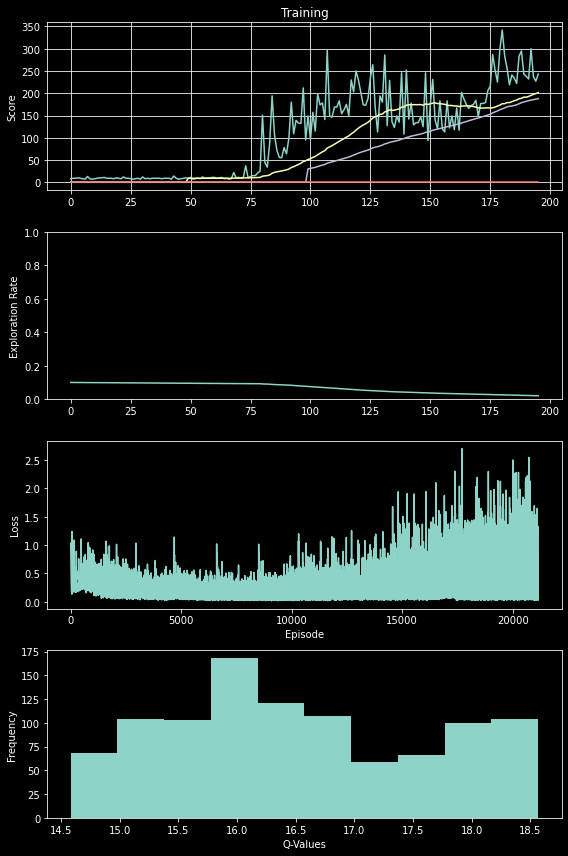

In [55]:
num_episodes = 2000
scores = []
exploration_rates = []
losses = []
qvalues = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        
        # Play one timestep of the game
        # em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        qvalues.append(policy_net(state).max().item())
        
        if memory.can_provide_sample(batch_size):
            # Sample random batch of experiences from replay memory
            experiences = memory.sample(batch_size)
            
            # Compute target Q-Values from bellman equation
            states, actions, rewards, next_states = extract_tensors(experiences) # PyTorch tensors with batch size
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, policy_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards # Target Q-Values according to bellman equation
            
            # Compute MSE loss and do backprop (only on policy_net)
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if em.done or timestep>1000: # Episode is over or runs for too long
            scores.append(timestep)
            exploration_rates.append(agent.get_exploration_rate())
            break

    if episode % target_update == 0: # Every few episodes
        target_net.load_state_dict(policy_net.state_dict()) # Update target net
        print("Episode Number:", episode)
        print("Average Score (100 episodes):", get_moving_average(scores, 100)[-1])
        plot(scores, exploration_rates, losses, qvalues)
    
    if get_moving_average(scores, 50)[-1] >= 200:
        break # Stop training if score is consistantly high
    
print("Episode Number:", episode)
print("Average Score (100 episodes):", get_moving_average(scores, 100)[-1])
plot(scores, exploration_rates, losses, qvalues)    
em.close()

## Results

In [56]:
num_episodes = 100
scores = []
qvalues = []

for episode in range(num_episodes):
    
    print("Episode Number:", episode)
    if is_ipython: display.clear_output(wait=True);
    em.reset()
    state = em.get_state()
    
    episode_losses = []
    for timestep in count():
        
        # Play one timestep of the game
        # em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        state = next_state
        qvalues.append(policy_net(state).max().item())
        if timestep>1000 or em.done:
            scores.append(timestep)
            break
        
em.close()

Episode Number: 99


Average Score: 281.37


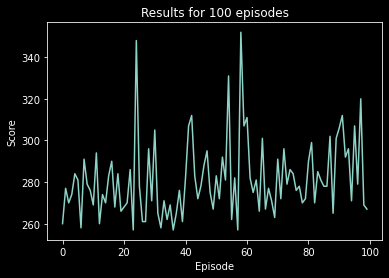

In [57]:
plt.title("Results for 100 episodes");
plt.xlabel("Episode");
plt.ylabel("Score");
plt.plot(scores);
print("Average Score:", np.mean(scores))

Cart-Pole is considered solved when the average is above 195